**bold text**# Mounting the Drive

In [1]:
# %%

# importing libs# importing libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import missingno as msno  ModuleNotFoundError: No module named 'numpy.rec'
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier

import folium
from folium.plugins import HeatMap
import plotly.express as px

print("all libs imported")

all libs imported


In [ ]:
from google.colab import drive
# Attempt to mount Google Drive. If it fails initially, a retry often works.
try:
    drive.mount('/content/drive')
except Exception as e:
    print(f"Initial mount failed: {e}. Retrying...")
    # Retry mounting
    try:
        drive.mount('/content/drive', force_remount=False)
    except Exception as retry_e:
        print(f"Retry mount failed: {retry_e}")

import pandas as pd

file_path = '/content/drive/MyDrive/data/hv_ts.csv'
df = pd.read_csv(file_path)

print("df created")

In [2]:
file_path = '/content/drive/MyDrive/data/hv_ts.csv'
df = pd.read_csv(file_path)


In [ ]:
print(df.head(10))

41753584


In [3]:
# renaming columns
df.rename(columns={'ts': 'time', 'device_profile': 'device_profile', 'devname': 'device_name', 'key': 'key', 'merged_column': 'value'}, inplace=True)

#gets all the keys other than error(no key is error in current db)
unique_values = df['key'].unique()
unique_values = [value for value in unique_values if 'error' not in str(value)]

# removing rows with specific values in the 'key' column

# Sample df so it wouldnt crash, Exculude this in colab
# df = df.sample(frac=0.1)  # Use 10% of the data for testing

values_to_exclude = [
    'devName', 'devEUI', 'time', 'snr', 'rssi', 'protocol_version',
    'firmware_version', 'hardware_version', 'sn', 'active',
    'images_urls', 'water_images_urls', 'serialnumber', 'Location',
    'gpio_in_1', 'gpio_in_2', 'gpio_in_3', 'gpio_in_4',
    'gpio_out_1', 'gpio_out_2', '420_ir_a_value', '420_ir_b_value',
    '420_ir_c_value', 'alarm_value'
]
column_name_to_check = 'key'
# Print shape before filtering
print(f"Shape of df before filtering: {df.shape}")
# Filter out rows where the value in the 'key' column is not in the list of values to exclude
#df_sample = df.sample(frac=0.1)  # Use 10% of the data for testing
df = df[~df[column_name_to_check].isin(values_to_exclude)]
# Print shape after filtering
print(f"Shape of df after filtering: {df.shape}")
unique_values_after = df['key'].unique()
print(len(df))

Shape of df before filtering: (41753584, 5)
Shape of df after filtering: (31174928, 5)
31174928


## SECTION 1: DATA CLEANING AND PREPROCESSING ##


In [4]:
import pandas as pd
import numpy as np
import gc # Import garbage collector to manage memory explicitly

# Print current count of NaN values in the original "value" column
print("Initial NaN count in 'value':", df['value'].isna().sum())

# Step 1: Make a backup copy of the original "value" column
# CRITICAL CHANGE: Using .copy(deep=True) ensures 'clean_value' is a *completely independent*
# copy in memory. This is essential to guarantee that any operations on 'clean_value'
# do NOT affect the original 'df['value']' column, and to avoid pandas' SettingWithCopyWarning.
df['clean_value'] = df['value'].copy(deep=True)

# Step 2: Remove leading and trailing whitespace from the backup column
# This operation is already vectorized by pandas and generally memory-efficient.
df['clean_value'] = df['clean_value'].astype(str).str.strip()

# Step 3: Convert the cleaned column to numeric. Non-convertible values become NaN.
# This operation (pd.to_numeric with errors='coerce') is highly optimized and vectorized,
# efficiently converting numeric strings and turning unconvertible ones into NaN.
df['clean_value'] = pd.to_numeric(df['clean_value'], errors='coerce')

# Step 4: Check what the conversion did by printing stats
print("=== Clean Value Column Stats ===")
print(f"Data type of 'clean_value': {df['clean_value'].dtype}")
print(f"Total NaN values in 'clean_value': {df['clean_value'].isna().sum()}")

# Step 5: Make a list of unique original values that were converted to NaN in 'clean_value'
# This diagnostic step efficiently works on the subset of data that became NaN.
nan_values = df.loc[df['clean_value'].isna(), 'value'].astype(str).str.strip()
nan_counts = nan_values.value_counts()
print("Unique original values converted to NaN and their counts:")
print(nan_counts)

# Define the conversion map (all keys in lowercase for consistency)
conversion_map = {
    "safe.png": 0,            # safe is 0
    "i-lb_closed.svg": 1,     # closed is 1
    "off": 0,                 # off assumed to be 0 (false)
    "i-lb_open.svg": 0,       # open is 0
    "i-lb closed.png": 1,     # closed is 1
    "i-lb open.png": 0,       # open is 0
    "i-lb closed1.png": 1,    # closed is 1
    "true": 1,                # true maps to 1
    "false": 0,               # false maps to 0
    "water alert.png": 1,     # water alert is 1
    "on": 1                   # on is 1
}

# Apply the conversion map to the 'value' column where 'clean_value' is NaN
# CRITICAL CHANGE: Replacing the inefficient Python for-loop with a single, vectorized pandas operation.
# This is the primary change to prevent memory overloads and crashes.
print("\nApplying conversion map using vectorized operations (memory-optimized)...")

# 1. Create a boolean mask identifying rows where 'clean_value' is currently NaN.
# This allows us to target our operations only on the necessary subset of data.
nan_mask = df['clean_value'].isna()

# 2. For the rows identified by 'nan_mask', take the *original* 'value' data.
# Convert these specific original strings to lowercase and strip whitespace *once* for mapping.
# Then, apply the 'conversion_map' using the highly optimized .map() method.
# Any values not found as keys in 'conversion_map' will result in NaN in this temporary series.
temp_mapped_values = df.loc[nan_mask, 'value'].astype(str).str.strip().str.lower().map(conversion_map)

# 3. Assign the results from 'temp_mapped_values' back to the 'clean_value' column,
# using the 'nan_mask' to ensure updates happen only where 'clean_value' was originally NaN.
df.loc[nan_mask, 'clean_value'] = temp_mapped_values

# Explicitly delete the temporary series to free up memory immediately, reducing peak usage.
del temp_mapped_values
gc.collect() # Trigger Python's garbage collector to free memory immediately

print("Conversion map applied.")

# Final conversion to numeric to ensure consistent data type across the entire 'clean_value' column.
# This handles any values that might have been introduced by the map, or any remaining unmapped
# strings that should ultimately be NaN.
df['clean_value'] = pd.to_numeric(df['clean_value'], errors='coerce')

print("\n--- After Conversion Map Application ---")
print("Data type of 'clean_value':", df['clean_value'].dtype)
print("Total NaN values in 'clean_value':", df['clean_value'].isna().sum())

# Including memory usage check at the end to help you monitor resource consumption.
print("\n--- DataFrame Memory Usage (Deep) ---")
# 'deep=True' provides a more accurate estimate of memory usage for object (string) columns.
print(df.info(memory_usage='deep'))

gc.collect() # Final garbage collection to ensure all temporary memory is released.


Initial NaN count in 'value': 0
=== Clean Value Column Stats ===
Data type of 'clean_value': float64
Total NaN values in 'clean_value': 2115545
Unique original values converted to NaN and their counts:
value
SAFE.png            1004285
i-LB_Closed.svg      938942
i-LB_OPEN.svg        110901
i-LB closed.png       19027
i-LB open.png         17023
i-LB closed1.png      12829
true                   5687
false                  5641
water alert.png        1203
on                        7
Name: count, dtype: int64

Applying conversion map using vectorized operations (memory-optimized)...
Conversion map applied.

--- After Conversion Map Application ---
Data type of 'clean_value': float64
Total NaN values in 'clean_value': 0

--- DataFrame Memory Usage (Deep) ---
<class 'pandas.core.frame.DataFrame'>
Index: 31174928 entries, 0 to 41753583
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   time            int64  
 1   device_profile  object 
 2   dev

0

In [5]:
print(df.head(10))

            time device_profile          device_name                   key  \
0  1721895028846     I-Link Box  I-Link Box R&D Test  ipec_pddata_avg_pd_c   
1  1721895028846  I-Link Box EA         I-Link Box 1               pulse_a   
2  1721895028846  I-Link Box EA         I-Link Box 1               pulse_b   
3  1721895028846  I-Link Box EA         I-Link Box 1               pulse_c   
4  1721895028846  I-Link Box EA         I-Link Box 1             voltage_a   
5  1721895028846  I-Link Box EA         I-Link Box 1             voltage_b   
6  1721895028846  I-Link Box EA         I-Link Box 1             voltage_c   
7  1721895028846  I-Link Box EA         I-Link Box 1             current_a   
8  1721895028846  I-Link Box EA         I-Link Box 1             current_b   
9  1721895028846  I-Link Box EA         I-Link Box 1             current_c   

                   value  clean_value  
0     46.28227402877302     46.282274  
1    146.90222152935894    146.902222  
2     886.50409935917

In [7]:
import pandas as pd
import gc # For explicit garbage collection

print("Starting DataFrame pivot process...")

pivot_index_cols = ['time', 'device_profile', 'device_name']

# Perform the pivot operation.
df_pivoted = df.pivot(
    index=pivot_index_cols,
    columns='key',
    values='clean_value'
).reset_index() # .reset_index() converts the pivot index back into regular columns.

# Optional: Add suffix to key column names for clarity
df_pivoted.columns = [
    col if col in pivot_index_cols
    else f"{col}_value"
    for col in df_pivoted.columns
]

# Explicitly run garbage collection to free up memory from intermediate objects created during pivot.
gc.collect()

# Display the results
print("\n--- Pivot Operation Complete ---")
print("Original DataFrame shape:", df.shape)
print("Pivoted DataFrame shape:", df_pivoted.shape)
print("\nPivoted DataFrame columns (first 20):")
# Printing only first 20 columns as there might be many 'key' columns.
print(df_pivoted.columns.tolist()[:20])
if len(df_pivoted.columns) > 20:
    print(f"... and {len(df_pivoted.columns) - 20} more columns.")
print("\nFirst few rows of Pivoted DataFrame:")
print(df_pivoted.head())

# Optional: Check for any missing values after pivot
# Missing values here would indicate that for a given (time, device_profile, device_name) combination,
# certain 'key' values did not exist in the original data.
print(f"\nMissing values per column (total for each pivoted key):")
print(df_pivoted.isnull().sum().head(20)) # Display first 20 for brevity
if len(df_pivoted.columns) > 20:
    print(f"... and missing counts for {len(df_pivoted.columns) - 20} more columns.")

# Print memory usage of the new pivoted DataFrame
print("\n--- Pivoted DataFrame Memory Usage (Deep) ---")
print(df_pivoted.info(memory_usage='deep'))
gc.collect() # Final garbage collection


Starting DataFrame pivot process...

--- Pivot Operation Complete ---
Original DataFrame shape: (31174928, 6)
Pivoted DataFrame shape: (1727094, 39)

Pivoted DataFrame columns (first 20):
['time', 'device_profile', 'device_name', '420_ir_a_value', '420_ir_b_value', '420_ir_c_value', 'IR_A_value', 'IR_B_value', 'IR_C_value', 'Water_Detection_Outside_value', 'alarm_value', 'current_a_value', 'current_b_value', 'current_c_value', 'harvesting_battery_power_value', 'harvesting_battery_voltage_value', 'hum_value', 'image_name_value', 'ipec_pddata_avg_pd_a_value', 'ipec_pddata_avg_pd_b_value']
... and 19 more columns.

First few rows of Pivoted DataFrame:
            time device_profile          device_name  420_ir_a_value  \
0  1721895028846     I-Link Box         I-Link Box 2             NaN   
1  1721895028846     I-Link Box  I-Link Box R&D Test       45.150734   
2  1721895028846  I-Link Box EA         I-Link Box 1             NaN   
3  1721895031828     I-Link Box         I-Link Box 2   

0

### Feature Engineering: Pivoting the DataFrame ###


In [7]:
import pandas as pd
import gc # For explicit garbage collection
from IPython.display import display # For better display of multiple dataframes

# --- IMPORTANT: This code assumes df_pivoted from the previous cell is available. ---

# --- Part 1: Save df_pivoted to CSV ---
# Define the output path. This will save it in your Google Drive 'data' folder.
# Ensure this path exists or choose a different one like '/content/df_pivoted.csv'
output_file_path = '/content/drive/MyDrive/data/df_pivoted.csv'

print(f"Saving df_pivoted to {output_file_path}...")
# index=False prevents pandas from writing the DataFrame index as a column in the CSV.
df_pivoted.to_csv(output_file_path, index=False)
print("df_pivoted saved successfully.")

gc.collect() # Clean up memory after saving

# --- Part 2: Investigate NaN values per device ---
print("\n--- Investigating NaN values per Key and Device ---")

# List of columns that are the pivoted 'key' values (excluding the index columns)
# We can infer these by taking all columns except the first three (time, device_profile, device_name)
key_columns = df_pivoted.columns[3:].tolist()

# List to store summary DataFrames for each key
nan_summary_list = []

# Loop through each pivoted key column to find its NaN distribution by device
for key_col in key_columns:
    # Filter rows where the current key_col has a NaN value
    nan_rows = df_pivoted[df_pivoted[key_col].isna()]

    # If there are any NaNs for this key, proceed with analysis
    if not nan_rows.empty:
        # Group by device_profile and device_name and count the number of NaNs
        # The .size() method counts the number of rows in each group.
        nan_counts_by_device = nan_rows.groupby(['device_profile', 'device_name']).size().reset_index(name='NaN_Count')

        # Add the current key_col name to this summary DataFrame for clarity
        nan_counts_by_device['Key_Column'] = key_col

        # Append to our main list
        nan_summary_list.append(nan_counts_by_device)

        print(f"Processed NaNs for '{key_col}'. Found {len(nan_rows)} total NaNs.")
    else:
        print(f"No NaNs found for '{key_col}'.")


# Concatenate all individual summary DataFrames into one large summary
if nan_summary_list:
    full_nan_summary = pd.concat(nan_summary_list, ignore_index=True)

    # Reorder columns for better readability
    full_nan_summary = full_nan_summary[['Key_Column', 'device_profile', 'device_name', 'NaN_Count']]

    print("\n--- Full NaN Summary by Key and Device (Top 50 rows) ---")
    # Display the full summary. Using display() for better rendering in Colab.
    display(full_nan_summary.head(50))
    if len(full_nan_summary) > 50:
        print(f"\n... displaying top 50 of {len(full_nan_summary)} rows. See full_nan_summary for all.")

    # Optional: You can sort this summary for easier analysis, e.g., by NaN_Count descending
    # full_nan_summary = full_nan_summary.sort_values(by='NaN_Count', ascending=False)

    print("\n--- End of NaN Investigation ---")

else:
    print("\nNo NaN values found across any of the pivoted key columns. (This is unexpected based on prior output.)")

gc.collect() # Final garbage collection

Saving df_pivoted to /content/drive/MyDrive/data/df_pivoted.csv...
df_pivoted saved successfully.

--- Investigating NaN values per Key and Device ---
Processed NaNs for '420_ir_a_value'. Found 1725919 total NaNs.
Processed NaNs for '420_ir_b_value'. Found 1725919 total NaNs.
Processed NaNs for '420_ir_c_value'. Found 1725919 total NaNs.
Processed NaNs for 'IR_A_value'. Found 681358 total NaNs.
Processed NaNs for 'IR_B_value'. Found 681350 total NaNs.
Processed NaNs for 'IR_C_value'. Found 680622 total NaNs.
Processed NaNs for 'Water_Detection_Outside_value'. Found 664925 total NaNs.
Processed NaNs for 'alarm_value'. Found 1722816 total NaNs.
Processed NaNs for 'current_a_value'. Found 713453 total NaNs.
Processed NaNs for 'current_b_value'. Found 713452 total NaNs.
Processed NaNs for 'current_c_value'. Found 713649 total NaNs.
Processed NaNs for 'harvesting_battery_power_value'. Found 711150 total NaNs.
Processed NaNs for 'harvesting_battery_voltage_value'. Found 711148 total NaNs.
Pr

,Key_Column,device_profile,device_name,NaN_Count
0,420_ir_a_value,I-Link Box,I-Link Box 2,306535
1,420_ir_a_value,I-Link Box,I-Link Box 3,108785
2,420_ir_a_value,I-Link Box,I-Link Box R&D Test,140456
3,420_ir_a_value,I-Link Box,JB1,167034
4,420_ir_a_value,I-Link Box,JB2,133934
5,420_ir_a_value,I-Link Box EA,I-Link Box 1,577722
6,420_ir_a_value,I-Link Box EA,Substation1,140467
7,420_ir_a_value,I-Link Box EA,Substation2,143208
8,420_ir_a_value,I-Link Box Tester,Signal Tester,7778
9,420_ir_b_value,I-Link Box,I-Link Box 2,306535



... displaying top 50 of 324 rows. See full_nan_summary for all.

--- End of NaN Investigation ---


31

from matplotlib import pyplot as plt
_df_0['NaN_Count'].plot(kind='hist', bins=20, title='NaN_Count')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('Key_Column').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('device_profile').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['NaN_Count'].plot(kind='line', figsize=(8, 4), title='NaN_Count')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['device_profile'].value_counts()
    for x_label, grp in _df_4.groupby('Key_Column')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Key_Column')
_ = plt.ylabel('device_profile')

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_5['Key_Column'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_5, x='NaN_Count', y='Key_Column', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_6['device_profile'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_6, x='NaN_Count', y='device_profile', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

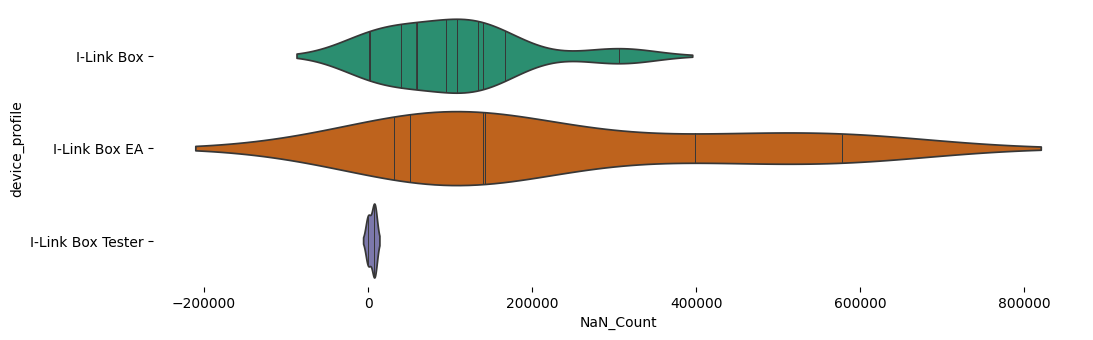

In [10]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_6['device_profile'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_6, x='NaN_Count', y='device_profile', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

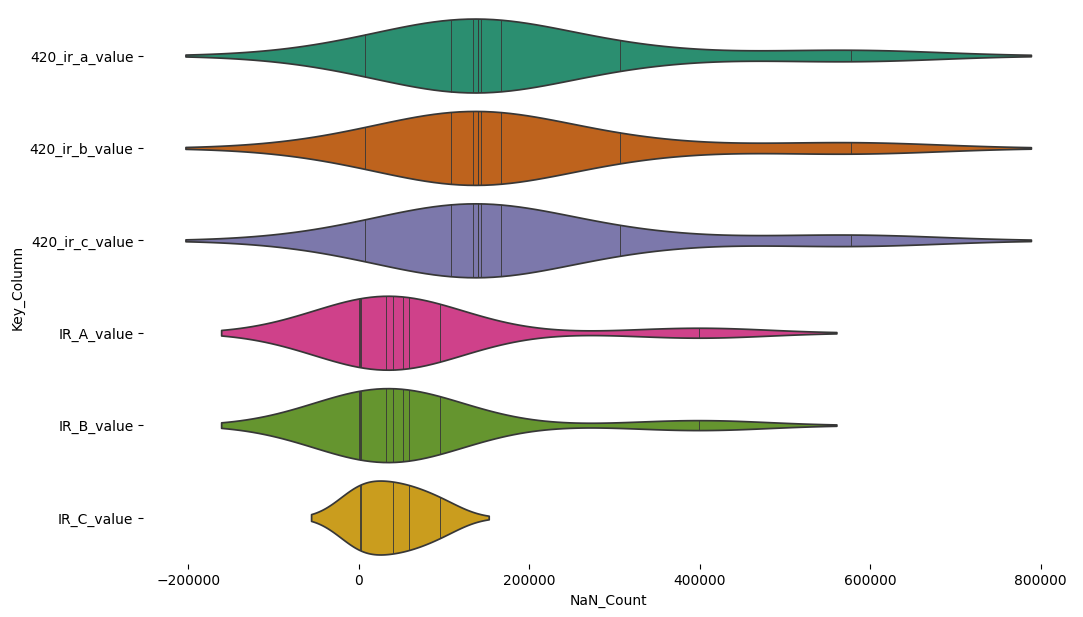

In [11]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_5['Key_Column'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_5, x='NaN_Count', y='Key_Column', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

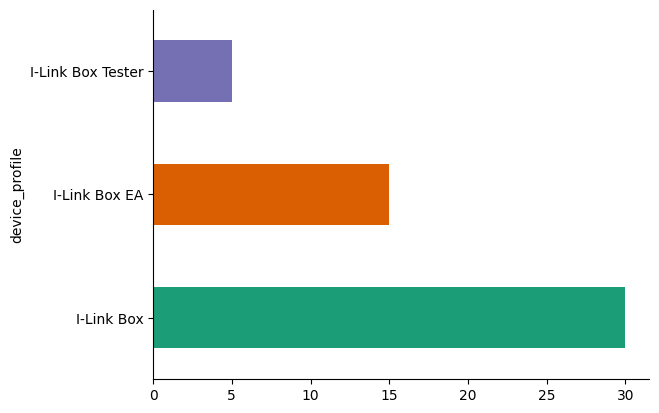

In [12]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('device_profile').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

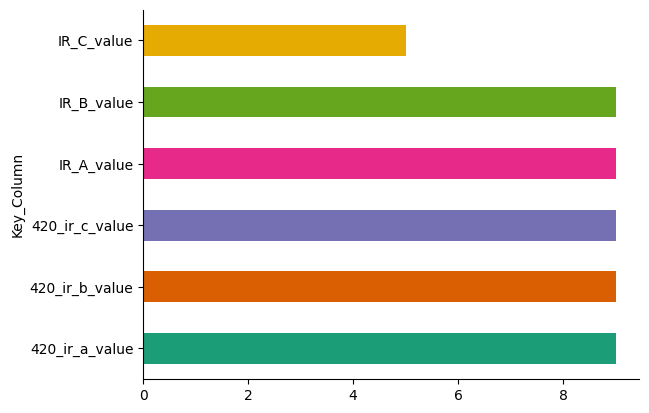

In [13]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('Key_Column').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

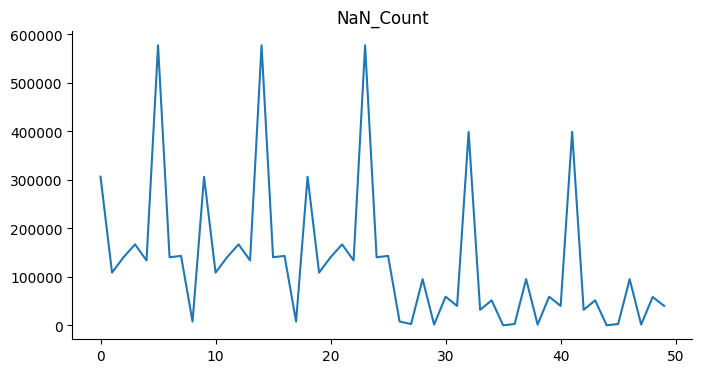

In [14]:
from matplotlib import pyplot as plt
_df_3['NaN_Count'].plot(kind='line', figsize=(8, 4), title='NaN_Count')
plt.gca().spines[['top', 'right']].set_visible(False)

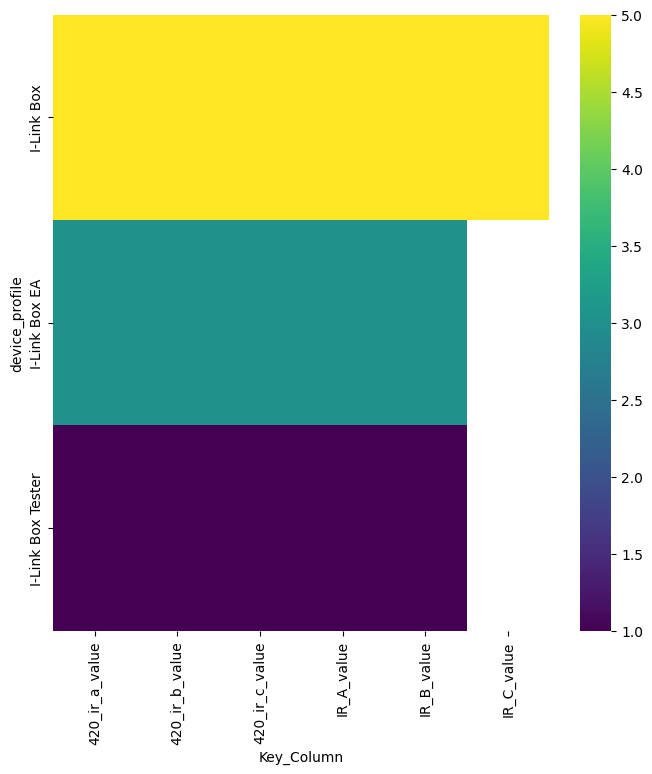

In [9]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['device_profile'].value_counts()
    for x_label, grp in _df_4.groupby('Key_Column')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Key_Column')
_ = plt.ylabel('device_profile')

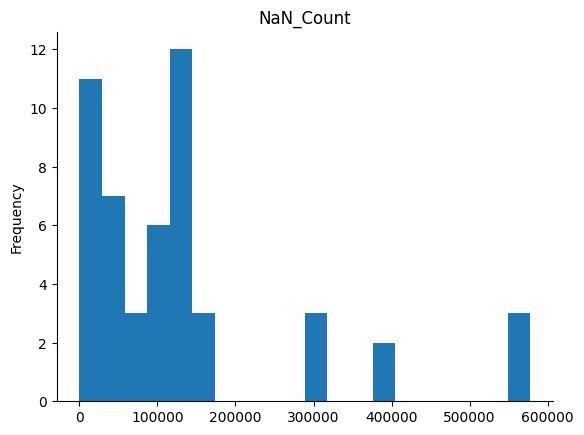

In [8]:
from matplotlib import pyplot as plt
_df_0['NaN_Count'].plot(kind='hist', bins=20, title='NaN_Count')
plt.gca().spines[['top', 'right',]].set_visible(False)

% analysis of NaN values

In [16]:
import pandas as pd
import gc # For explicit garbage collection
from IPython.display import display # For better display of multiple dataframes

# --- IMPORTANT: This code assumes df_pivoted from previous cells is available. ---
# --- It also relies on 'full_nan_summary' which was generated in the previous NaN investigation cell. ---

print("Starting NaN percentage analysis...")

# --- Step 1: Calculate Total Observations for each Device Combination ---
# We use df_pivoted to get the total count of unique (time, device_profile, device_name) combinations
# for each device. This represents the total number of rows a device could potentially have.
print("Calculating total observations per device...")
total_observations_per_device = df_pivoted.groupby(['device_profile', 'device_name']).size().reset_index(name='Total_Observations')
print("Total observations per device calculated.")
# display(total_observations_per_device.head()) # Uncomment to inspect this intermediate DataFrame

# --- Step 2: Merge Total Observations with the Full NaN Summary ---
# We will merge full_nan_summary (from the previous cell) with total_observations_per_device.
# This will add the 'Total_Observations' column to our NaN summary.
if 'full_nan_summary' in locals(): # Check if full_nan_summary exists from previous cell
    print("Merging NaN summary with total observations...")
    # Merge on the common device identifier columns
    nan_summary_with_totals = pd.merge(
        full_nan_summary,
        total_observations_per_device,
        on=['device_profile', 'device_name'],
        how='left' # Use a left merge to keep all entries from full_nan_summary
    )
    print("Merge complete.")

    # --- Step 3: Calculate Percentage ---
    print("Calculating NaN percentages...")
    nan_summary_with_totals['NaN_Percentage'] = (
        nan_summary_with_totals['NaN_Count'] / nan_summary_with_totals['Total_Observations']
    ) * 100
    print("NaN percentages calculated.")

    # --- Step 4: Display Results ---
    print("\n--- Full NaN Summary with Percentages (Top 50 rows, sorted by percentage) ---")
    # Sort for easier interpretation: highest percentage NaNs first
    nan_summary_with_totals_sorted = nan_summary_with_totals.sort_values(
        by='NaN_Percentage',
        ascending=False
    )
    display(nan_summary_with_totals_sorted.head(50))
    if len(nan_summary_with_totals_sorted) > 50:
        print(f"\n... displaying top 50 of {len(nan_summary_with_totals_sorted)} rows. See nan_summary_with_totals_sorted for all.")

    # --- Step 5: Save the Full NaN Percentage Analysis Table to CSV ---
    output_percentage_csv_path = '/content/drive/MyDrive/data/nan_percentage_summary.csv'
    print(f"\nSaving full NaN percentage summary to {output_percentage_csv_path}...")
    nan_summary_with_totals_sorted.to_csv(output_percentage_csv_path, index=False)
    print("Full NaN percentage summary saved successfully.")

    # Optional: Display some statistics about the percentages
    print("\n--- NaN Percentage Statistics (Overall) ---")
    print(nan_summary_with_totals_sorted['NaN_Percentage'].describe())

else:
    print("Error: 'full_nan_summary' DataFrame not found. Please ensure the previous NaN investigation cell was run.")

gc.collect() # Final garbage collection
print("\nNaN percentage analysis complete.")

Starting NaN percentage analysis...
Calculating total observations per device...
Total observations per device calculated.
Merging NaN summary with total observations...
Merge complete.
Calculating NaN percentages...
NaN percentages calculated.

--- Full NaN Summary with Percentages (Top 50 rows, sorted by percentage) ---


,Key_Column,device_profile,device_name,NaN_Count,Total_Observations,NaN_Percentage
251,temperature_value,I-Link Box Tester,Signal Tester,7778,7778,100.000000
250,temperature_value,I-Link Box EA,Substation2,143208,143208,100.000000
249,temperature_value,I-Link Box EA,Substation1,140467,140467,100.000000
248,temperature_value,I-Link Box EA,I-Link Box 1,577722,577722,100.000000
245,temperature_value,I-Link Box,I-Link Box R&D Test,141631,141631,100.000000
244,temperature_value,I-Link Box,I-Link Box 3,108785,108785,100.000000
243,temperature_value,I-Link Box,I-Link Box 2,306535,306535,100.000000
26,420_ir_c_value,I-Link Box Tester,Signal Tester,7778,7778,100.000000
25,420_ir_c_value,I-Link Box EA,Substation2,143208,143208,100.000000
24,420_ir_c_value,I-Link Box EA,Substation1,140467,140467,100.000000



... displaying top 50 of 324 rows. See nan_summary_with_totals_sorted for all.

Saving full NaN percentage summary to /content/drive/MyDrive/data/nan_percentage_summary.csv...
Full NaN percentage summary saved successfully.

--- NaN Percentage Statistics (Overall) ---
count    324.000000
mean      42.631964
std       36.810243
min        0.271833
25%        1.478529
50%       35.250608
75%       87.537804
max      100.000000
Name: NaN_Percentage, dtype: float64

NaN percentage analysis complete.
